<a href="https://colab.research.google.com/github/owgee/supply-chain-analytics/blob/main/SOP_Green_Apple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Green Apple: Supply Planning case

Green Apple (GA) products are sold through retailers nationwide. Their operations consist of assembling purchases parts into a multipurpose gardening tool. Because of the limited equipment and space required for its operations, GA’s capacity is mainly determined by the size of its workforce.

Demand for GA’s products is highly seasonal peaking around April. In anticipation of the next season’s demand GA starts planning in the Fall for months of January through June. To meet the peak demand, GA can hire additional workers, subcontract some of the work or build up inventory during the slow months. It could also shift some demand in time by using promotions. Please determine the best use of these options by building an aggregate plan for: regular labor, overtime labor, number of units produced, inventory, subcontracting, and stockouts (backlogged demand).

```
+----------+-----------------+
| Month    | Demand Forecast |
+----------+-----------------+
| January  | 1,600           |
| February | 3,000           |
| March    | 3,200           |
| April    | 3,800           |
| May      | 2,200           |
| June     | 2,200           |
+----------+-----------------+

+-----------------------------+---------------+
| Item                        | Cost          |
+-----------------------------+---------------+
| Materials                   | $10/unit      |
| Inventory holding cost      | $2/unit/month |
| Marginal cost of a stockout | $5/unit/month |
| Hiring and training costs   | $300/worker   |
| Layoff cost                 | $500/worker   |
| Labor hours required        | 4/unit        |
| Regular time cost           | $4/hour       |
| Over time cost              | $6/hour       |
| Cost of subcontracting      | $30/unit      |
+-----------------------------+---------------+
```

* number of workers in the beginning of January: 80
* Initial inventory: 1000
* Minimum inventory at the end of June: 500 (business continuity) and no backlog
* Maximum use of overtime: 10 hours per worker
* Use of subcontracting: unlimited or limited to 500 per month
* Regular unit sales price: \$ 40
* Promotion price: \$ 39, results in an increase of consumption by 10% in the months of the promotion, and shifts 20% of demand from the future two months to the current month.

### Install and import packages

In [3]:
# Install and import packages
!pip install tabulate
!pip install gurobipy
import numpy as np
from gurobipy import Model, GRB, quicksum
from tabulate import tabulate
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 43.6 MB/s eta 0:00:00


### Raw Data

In [4]:
### User defined variables
promote = 0
month = 4
base_price = 40
promotion_price = base_price - 1
consumption = 0.10
forward_buy = 0.20

F = np.array([0, 1600, 3000, 3200, 3800, 2200, 2200])

### Variables based on input
n_months = len(F)-1
F = np.append(F, [0, 0])

### Minimize cost using Gurobi integer optimizer

In [5]:
def plot_inventory():
  t_values = list(range(1, n_months + 1))

  plt.plot(t_values, [I[t].x for t in t_values], marker='o', label='Inventory')
  plt.plot(t_values, [P[t].x for t in t_values], marker='s', label='Production')
  plt.plot(t_values, [D[t].x for t in t_values], marker='D', label='Demand')
  plt.plot(t_values, [S[t].x for t in t_values], marker='^', label='Stockout')
  plt.plot(t_values, [C[t].x for t in t_values], marker='x', label='Subcontracting')

  # Adding labels and legend
  plt.xlabel('Period')
  plt.ylabel('')
  plt.legend(loc='best')
  plt.title('Aggregate Plan')
  plt.grid(axis='y')

  # Show the plot
  plt.show()

### Optimization problem

***Minimize Cost***

***subject to:***
  Workforce constraint

  Inventory balance constraint

  Production Capacity constraint

  Overtime constraint
  
  Demand and Stockout constraint

***Decision Variables***

Ht  = Number of employees hired at the beginning of month t, t = 1, ..., 6

Lt  = Number of employees laid off at the beginning of month t, t = 1, ..., 6

Wt  = Workforce size for month t, t = 1, ..., 6

Ot  = Number of overtime hours worked in month t, t = 1, ..., 6

It  = Inventory at the end of month t, t = 1, ..., 6

St  = Number of units stocked out at the end of month t, t = 1, ..., 6

Ct  = Number of units subcontracted for month t, t = 1, ..., 6

Pt  = Production in month t, t = 1, ..., 6

Dt  = Computed Demand in month t, t = 1, ..., 6

Restricted license - for non-production use only - expires 2025-11-24
+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
| Period | Hired | Laid Off | Workforce | Overtime | Inventory | Stockout | Subcontract | Production | Demand | Price |
|    (t) |   (H) |      (L) |       (W) |      (O) |       (O) |      (S) |         (C) |        (P) |    (D) |  (Pr) |
+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
|      0 |  -0.0 |     -0.0 |      80.0 |     -0.0 |    1000.0 |      0.0 |        -0.0 |       -0.0 |   -0.0 |   nan |
|      1 |   0.0 |     16.0 |      64.0 |     -0.0 |    1960.0 |     -0.0 |        -0.0 |     2560.0 | 1600.0 |  40.0 |
|      2 |   0.0 |     -0.0 |      64.0 |     -0.0 |    1520.0 |     -0.0 |         0.0 |     2560.0 | 3000.0 |  40.0 |
|      3 |   0.0 |     -0.0 |      64.0 |     -0.0 |     880.0 |     -0.0 |         0.0 | 

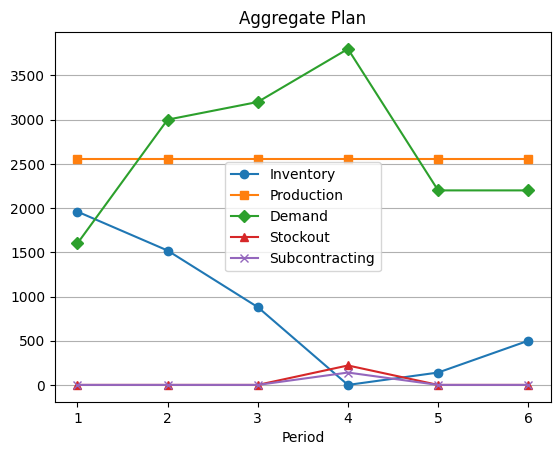

In [6]:
# Create a Gurobi model
model = Model("MinimizeCost")

H = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months+1)}
L = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months+1)}
W = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months+1)}
O = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months+1)}
I = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months+1)}
S = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months+1)}
C = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months+1)}
P = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months+1)}
D = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months+1)}

# Update the model
model.update()

# Set objective function - Total cost = Production & Transportation cost across network + Fixed cost of low cap line + fixed cost of high cap line
model.setObjective(
    quicksum( 300*H[t] + 500*L[t] + 640*W[t] + 6*O[t] + 2*I[t] + 5*S[t] + 30*C[t] + 10*P[t] for t in range(1, n_months+1) ),
    GRB.MINIMIZE)

### Constraints
for t in range(1, n_months+1):

  # Workforce size for each month is based on hiring and layoffs, W_t = W_{t-1} + H_t - L_t
  model.addConstr(W[0] == 80, name=f"Workforce_Beg")
  model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_size_constraint_{t}")

  # Demand constraints
  if promote == 0:
      model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
  else:
      if t == month:
          model.addConstr(D[t] == F[t] * (1 + consumption) + forward_buy * (F[t+1] + F[t+2]), name=f"D_constraint_{t}")
      else:
          if t <= 2 + promote:
              if t > promote:
                  model.addConstr(D[t] == (1 - forward_buy) * F[t], name=f"D_constraint_{t}")
              else:
                  model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
          else:
              model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")

  # Inventory balance constraint: I_{t-1} + P_t + C_t = D_t + S_{t-1} + I_t - S_t
  model.addConstr(I[0] == 1000, name=f"Inventory_Beg")
  model.addConstr(I[t-1] + P[t] + C[t] - D[t] - S[t-1] - I[t] + S[t] == 0, name=f"Inventory_constraint_{t}")
  model.addConstr(I[n_months] >= 500, name=f"Inventory_End")

  # Stockout constraint: No stockout at the end
  model.addConstr(S[n_months] == 0, name=f"Stockout_End")

  # Production <= Capacity P_t <= 40 W_t + O_t/4
  model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Capacity_constraint_{t}")

  # Overtime constraint O_t <= 10 W_t
  model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_constraint_{t}")


# Suppress optimization output
model.Params.OutputFlag = 0

# Optimize the model
model.optimize()

### Calculate price
Pr = np.zeros(n_months+1)
for t in range(0, n_months + 1):
  if promote == 1 and t == month:
    Pr[t] = promotion_price
  else:
    Pr[t] = base_price
  if t == 0:
    Pr[t] = np.nan

### Total revenue = sumproduct (demand*price)
revenue = sum([D[t].x * Pr[t] for t in range(1, n_months + 1)])

# Store result in table format and print
opt_results = [[t] + [H[t].x] + [L[t].x] + [W[t].x] + [O[t].x] + [I[t].x] + [S[t].x] + [C[t].x] + [P[t].x] + [D[t].x] + [Pr[t]] for t in range(0, n_months + 1)]

headers = ["Period\n(t)"] + ["Hired\n(H)"] + ["Laid Off\n(L)"] + ["Workforce\n(W)"] + ["Overtime\n(O)"] + ["Inventory\n(O)"] + ["Stockout\n(S)"] + ["Subcontract\n(C)"] + ["Production\n(P)"] + ["Demand\n(D)"] + ["Price\n(Pr)"]
print(tabulate(opt_results, headers=headers, tablefmt="pretty", stralign="right"))

print(f"Minimum Cost : $ {model.objVal:,.2f}")
print(f"Total Revenue: $ {revenue:,.2f}")
print(f"Profit       : $ {(revenue-model.objVal):,.2f}")

plot_inventory()


In [7]:
january_cost_initial = 300*H[1].x + 500*L[1].x + 640*W[1].x + 6*O[1].x + 2*I[1].x + 5*S[1].x + 30*C[1].x + 10*P[1].x

print(f"Simulated Incurred Cost for January: $ {january_cost_initial:,.2f}")

Simulated Incurred Cost for January: $ 78,480.00


**QN 2:** One month has passed and you are in the end of January. It turned out that demand in January was a bit slower 1500 units, instead of 1600.  Also your forecasting team projects that demand in April is going to be 3900. They also added demand in July to be 1100.

In [8]:
F = np.array([0, 1500, 3000, 3200, 3900, 2200, 2200,1100])

### Variables based on input
n_months = len(F)-1
F = np.append(F, [0, 0])

+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
| Period | Hired | Laid Off | Workforce | Overtime | Inventory | Stockout | Subcontract | Production | Demand | Price |
|    (t) |   (H) |      (L) |       (W) |      (O) |       (O) |      (S) |         (C) |        (P) |    (D) |  (Pr) |
+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
|      0 |   0.0 |      0.0 |      80.0 |      0.0 |    1000.0 |      0.0 |         0.0 |        0.0 |    0.0 |   nan |
|      1 |   0.0 |     14.0 |      66.0 |      0.0 |    2140.0 |      0.0 |         0.0 |     2640.0 | 1500.0 |  40.0 |
|      2 |   0.0 |      0.0 |      66.0 |      0.0 |    1780.0 |      0.0 |         0.0 |     2640.0 | 3000.0 |  40.0 |
|      3 |   0.0 |      0.0 |      66.0 |      0.0 |    1220.0 |      0.0 |         0.0 |     2640.0 | 3200.0 |  40.0 |
|      4 |   0.0 |      0.0 |      66.0 

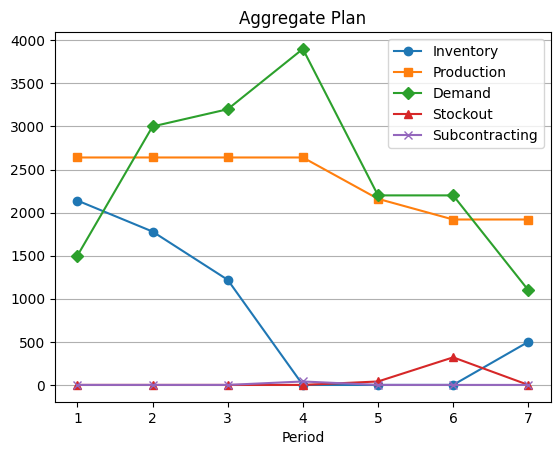

In [9]:
# Create a Gurobi model
model = Model("MinimizeCost")

H = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months+1)}
L = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months+1)}
W = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months+1)}
O = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months+1)}
I = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months+1)}
S = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months+1)}
C = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months+1)}
P = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months+1)}
D = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months+1)}

# Update the model
model.update()

# Set objective function - Total cost = Production & Transportation cost across network + Fixed cost of low cap line + fixed cost of high cap line
model.setObjective(
    quicksum( 300*H[t] + 500*L[t] + 640*W[t] + 6*O[t] + 2*I[t] + 5*S[t] + 30*C[t] + 10*P[t] for t in range(1, n_months+1) ),
    GRB.MINIMIZE)

### Constraints
for t in range(1, n_months+1):

  # Workforce size for each month is based on hiring and layoffs, W_t = W_{t-1} + H_t - L_t
  model.addConstr(W[0] == 80, name=f"Workforce_Beg")
  model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_size_constraint_{t}")

  # Demand constraints
  if promote == 0:
      model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
  else:
      if t == month:
          model.addConstr(D[t] == F[t] * (1 + consumption) + forward_buy * (F[t+1] + F[t+2]), name=f"D_constraint_{t}")
      else:
          if t <= 2 + promote:
              if t > promote:
                  model.addConstr(D[t] == (1 - forward_buy) * F[t], name=f"D_constraint_{t}")
              else:
                  model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
          else:
              model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")

  # Inventory balance constraint: I_{t-1} + P_t + C_t = D_t + S_{t-1} + I_t - S_t
  model.addConstr(I[0] == 1000, name=f"Inventory_Beg")
  model.addConstr(I[t-1] + P[t] + C[t] - D[t] - S[t-1] - I[t] + S[t] == 0, name=f"Inventory_constraint_{t}")
  model.addConstr(I[n_months] >= 500, name=f"Inventory_End")

  # Stockout constraint: No stockout at the end
  model.addConstr(S[n_months] == 0, name=f"Stockout_End")

  # Production <= Capacity P_t <= 40 W_t + O_t/4
  model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Capacity_constraint_{t}")

  # Overtime constraint O_t <= 10 W_t
  model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_constraint_{t}")


# Suppress optimization output
model.Params.OutputFlag = 0

# Optimize the model
model.optimize()

### Calculate price
Pr = np.zeros(n_months+1)
for t in range(0, n_months + 1):
  if promote == 1 and t == month:
    Pr[t] = promotion_price
  else:
    Pr[t] = base_price
  if t == 0:
    Pr[t] = np.nan

### Total revenue = sumproduct (demand*price)
revenue = sum([D[t].x * Pr[t] for t in range(1, n_months + 1)])

# Store result in table format and print
opt_results = [[t] + [H[t].x] + [L[t].x] + [W[t].x] + [O[t].x] + [I[t].x] + [S[t].x] + [C[t].x] + [P[t].x] + [D[t].x] + [Pr[t]] for t in range(0, n_months + 1)]

headers = ["Period\n(t)"] + ["Hired\n(H)"] + ["Laid Off\n(L)"] + ["Workforce\n(W)"] + ["Overtime\n(O)"] + ["Inventory\n(O)"] + ["Stockout\n(S)"] + ["Subcontract\n(C)"] + ["Production\n(P)"] + ["Demand\n(D)"] + ["Price\n(Pr)"]
print(tabulate(opt_results, headers=headers, tablefmt="pretty", stralign="right"))

print(f"Minimum Cost : $ {model.objVal:,.2f}")
print(f"Total Revenue: $ {revenue:,.2f}")
print(f"Profit       : $ {(revenue-model.objVal):,.2f}")

plot_inventory()


In [10]:
january_cost_final = 300*H[1].x + 500*L[1].x + 640*W[1].x + 6*O[1].x + 2*I[1].x + 5*S[1].x + 30*C[1].x + 10*P[1].x

print(f"Simulated Incurred Cost for January: $ {january_cost_final:,.2f}")

Simulated Incurred Cost for January: $ 79,920.00


**Question 3**: What impact did the change of demand in January have on costs incurred in January, compared to the planned costs computed in Step 1? Assume that January production went according to the plan developed in December.

In [11]:
cost_difference = january_cost_final - january_cost_initial
print(f"Cost difference: $ {cost_difference:,.2f}")

Cost difference: $ 1,440.00


*The change of demand in January led to an increase in cost by $1,440.00*

**Question 4:** Obtain the updated sales and operations plan for the months of February through July, while accounting for the realized demand in January (and hence the extra inventory) and updated forecasts for April and July. Compare it with the original plan from Step 1 (show the graph for the updated plan). What is the cost difference between the plans for the months Feb through June?

In [16]:
# Original demand forecast
F_original = np.array([0, 1600, 3000, 3200, 3800, 2200, 2200])

# Updated demand forecasts
F_updated = np.array([0, 1500, 3000, 3200, 3900, 2200, 2200 ,1100])

def create_model(n_months, F, promote, month, consumption, forward_buy, base_price, promotion_price):
    model = Model("MinimizeCost")

    H = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months+1)}
    L = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months+1)}
    W = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months+1)}
    O = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months+1)}
    I = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months+1)}
    S = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months+1)}
    C = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months+1)}
    P = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months+1)}
    D = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months+1)}

    # Update the model
    model.update()

    # Set objective function
    model.setObjective(
        sum(300*H[t] + 500*L[t] + 640*W[t] + 6*O[t] + 2*I[t] + 5*S[t] + 30*C[t] + 10*P[t] for t in range(1, n_months+1)),
        GRB.MINIMIZE)

    # Constraints
    for t in range(1, n_months+1):
        # Workforce size constraint
        model.addConstr(W[0] == 80, name=f"Workforce_Beg")
        model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_size_constraint_{t}")

        # Demand constraints
        if promote == 0:
            model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
        else:
            if t == month:
                model.addConstr(D[t] == F[t] * (1 + consumption) + forward_buy * (F[t+1] + F[t+2]), name=f"D_constraint_{t}")
            else:
                if t <= 2 + promote:
                    if t > promote:
                        model.addConstr(D[t] == (1 - forward_buy) * F[t], name=f"D_constraint_{t}")
                    else:
                        model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
                else:
                    model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")

        # Inventory balance constraint
        model.addConstr(I[0] == 1000, name=f"Inventory_Beg")
        model.addConstr(I[t-1] + P[t] + C[t] - D[t] - S[t-1] - I[t] + S[t] == 0, name=f"Inventory_constraint_{t}")
        model.addConstr(I[n_months] >= 500, name=f"Inventory_End")

        # Stockout constraint
        model.addConstr(S[n_months] == 0, name=f"Stockout_End")

        # Production <= Capacity constraint
        model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Capacity_constraint_{t}")

        # Overtime constraint
        model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_constraint_{t}")

    # Suppress optimization output
    model.Params.OutputFlag = 0

    return model, H, L, W, O, I, S, C, P, D

    # Function to calculate revenue
def calculate_revenue(D, Pr, n_months):
    return sum(D[t].x * Pr[t] for t in range(1, n_months + 1))

    # Function to print results
def print_results(opt_results, model, revenue):
    headers = ["Period\n(t)", "Hired\n(H)", "Laid Off\n(L)", "Workforce\n(W)", "Overtime\n(O)",
               "Inventory\n(O)", "Stockout\n(S)", "Subcontract\n(C)", "Production\n(P)",
               "Demand\n(D)", "Price\n(Pr)"]
    print(tabulate(opt_results, headers=headers, tablefmt="pretty", stralign="right"))
    print(f"Minimum Cost : $ {model.objVal:,.2f}")
    print(f"Total Revenue: $ {revenue:,.2f}")
    print(f"Profit       : $ {(revenue - model.objVal):,.2f}")


Original Plan:
+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
| Period | Hired | Laid Off | Workforce | Overtime | Inventory | Stockout | Subcontract | Production | Demand | Price |
|    (t) |   (H) |      (L) |       (W) |      (O) |       (O) |      (S) |         (C) |        (P) |    (D) |  (Pr) |
+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+
|      0 |  -0.0 |     -0.0 |      80.0 |     -0.0 |    1000.0 |      0.0 |        -0.0 |       -0.0 |   -0.0 |   nan |
|      1 |   0.0 |     16.0 |      64.0 |     -0.0 |    1960.0 |     -0.0 |        -0.0 |     2560.0 | 1600.0 |    40 |
|      2 |   0.0 |     -0.0 |      64.0 |     -0.0 |    1520.0 |     -0.0 |         0.0 |     2560.0 | 3000.0 |    40 |
|      3 |   0.0 |     -0.0 |      64.0 |     -0.0 |     880.0 |     -0.0 |         0.0 |     2560.0 | 3200.0 |    40 |
|      4 |   0.0 |     -0

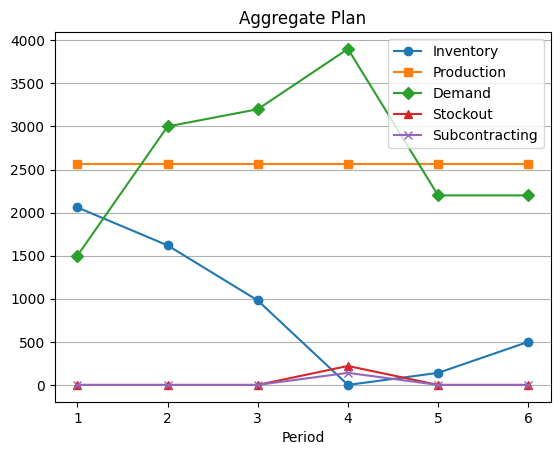

In [17]:

# Other parameters
promote = 0
month = 4
base_price = 40
promotion_price = base_price - 1
consumption = 0.10
forward_buy = 0.20

n_months = len(F_original) - 1

# Optimization model for the original plan
model_original, H, L, W, O, I, S, C, P, D = create_model(n_months, F_original, promote, month,
                                                         consumption, forward_buy, base_price, promotion_price)
model_original.optimize()

# Calculate prices
Pr = [np.nan] + [base_price] * n_months

# Calculate revenue
revenue_original = calculate_revenue(D, Pr, n_months)

# Store results in table format and print
opt_results_original = [[t] + [H[t].x] + [L[t].x] + [W[t].x] + [O[t].x] + [I[t].x] + [S[t].x] + [C[t].x] +
                        [P[t].x] + [D[t].x] + [Pr[t]] for t in range(0, n_months + 1)]

print("Original Plan:")
print_results(opt_results_original, model_original, revenue_original)

# Update the demand forecasts in the optimization model for the updated plan
model_updated, H, L, W, O, I, S, C, P, D = create_model(n_months, F_updated, promote, month,
                                                       consumption, forward_buy, base_price, promotion_price)
model_updated.optimize()

# Calculate revenue for the updated plan
revenue_updated = calculate_revenue(D, Pr, n_months)

# Store results in table format and print
opt_results_updated = [[t] + [H[t].x] + [L[t].x] + [W[t].x] + [O[t].x] + [I[t].x] + [S[t].x] + [C[t].x] +
                       [P[t].x] + [D[t].x] + [Pr[t]] for t in range(0, n_months + 1)]

print("\nUpdated Plan:")
print_results(opt_results_updated, model_updated, revenue_updated)

# Calculate cost difference between the original and updated plans for February through June
cost_difference = sum([P[t].x * 640 + O[t].x * 6 + I[t].x * 2 + S[t].x * 5 + C[t].x * 30 for t in range(2, n_months + 1)])
print(f"\nCost Difference (Feb-Jun): ${cost_difference:,.2f}")

plot_inventory()